# GreenGuardian 🌎🛡️

Green Guardian utilizes AWS SageMaker and associated cloud technologies to deploy an advanced deep learning model for precise plastic object detection in images. Through SageMaker, the model is efficiently trained and tuned. The detection process is orchestrated using Step Functions, triggered by AWS EventBridge's CRON jobs on scheduled intervals. This approach enables cost-effective, scalable, and accurate plastic detection, aligning with the goal of a greener planet!

In [2]:
# module imports
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import random
import glob
import os
import shutil
import platform
import sys
import sagemaker
from sagemaker import get_execution_role
from sagemaker import image_uris
from IPython.display import display
from PIL import Image
from sklearn.model_selection import train_test_split

## DATA ANALYSIS 📊:

In [3]:
# create a dataframe for the train and validation imgs:
print("VALIDATION IMGS RAW LABEL DATA:")
df_val = pd.read_csv('data/validation/labels/detections.csv')
display(df_val.head())

print("\nTRAIN IMGS RAW LABEL DATA:")
df_train = pd.read_csv('data/train/labels/detections.csv')
display(df_train.head())

VALIDATION IMGS RAW LABEL DATA:


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964201,0.071038,0.800546,0,0,0,0,0
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0



TRAIN IMGS RAW LABEL DATA:


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938


### DATA ANALYSIS NOTE #1:

- The CSV-data extracted above for the training labels and validation labels contains information about **all** the classes in the dataset we acquired from Google's Open Images Dataset.

- I will be restricting this data to contain information about the images that have **only** the unique **label_name** corresponding to plastic-images for this project's purpose, as we do not care about other types of images, this model is solely aimed to be trained on the bounding boxes drawn around the plastic entities in the image.

- In the code below, I've retrieved how many images we're working with for each type, and filtered them out by img-id for further use.

In [5]:
# paths to the training and validation images.
img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]

# lists to store the respective img ids.
train_img_ids = []
val_img_ids = []

# total amt of img analysis.
def count_total_imgs():
    
    # img counters.
    total_val_imgs = 0
    total_train_imgs = 0

    # counter-loop.
    img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]
    for path in img_paths:
        if('validation' in path):
            for img in glob.glob(path):
                total_val_imgs += 1
        if('train' in path):
            for img in glob.glob(path):
                total_train_imgs += 1

    print("THE TOTAL NUMBER OF VALIDATION IMGS IS: ", total_val_imgs)
    print("THE TOTAL NUMBER OF TRAIN IMGS IS: ", total_train_imgs)

# retrieving each img-id from each of the paths.
def get_desired_img_ids(path):
    
    # retrieval.
    for img in glob.glob(path):
        if 'train' in path:
            img_id = img.split("/")[-1].split(".")[0]
            train_img_ids.append(img_id)
        elif 'validation' in path:
            img_id = img.split("/")[-1].split(".")[0]
            val_img_ids.append(img_id)

# func calls.
count_total_imgs()
for path in img_paths:
    get_desired_img_ids(path)

THE TOTAL NUMBER OF VALIDATION IMGS IS:  9
THE TOTAL NUMBER OF TRAIN IMGS IS:  650


### DATA ANALYSIS NOTE #2:

- As stated before, I will be restricting this data to contain information about the images that have **only** the unique **label_name** corresponding to plastic-images. Hence let's extract the given class identifier for the plastic images, and filter only those in our raw data.

- I've also included a visualization for how the csv data of a randomly chosen img-id from our desired class identifier would look.

In [6]:
df_val_classes = pd.read_csv('data/validation/metadata/classes.csv', names = ['className', 'Object'])
df_train_classes = pd.read_csv('data/train/metadata/classes.csv', names = ['className', 'Object'])

val_plastic_class_identifier = df_val_classes[df_val_classes['Object'] == 'Plastic bag']
train_plastic_class_identifier = df_train_classes[df_train_classes['Object'] == 'Plastic bag']

print(val_plastic_class_identifier, "----> Plastic Class Identifier for Validation Images")
print("\n", train_plastic_class_identifier, "----> Plastic Class Identifier for Training Images")

     className       Object
327  /m/05gqfk  Plastic bag ----> Plastic Class Identifier for Validation Images

      className       Object
327  /m/05gqfk  Plastic bag ----> Plastic Class Identifier for Training Images


In [15]:
# img paths.
img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]

# func to sample a random row with the desired class identifier -- /m/05gqfk
def sample_random_row_from_df(path):
    
    df = ""
    if 'train' in path:
        df,ids_to_check = df_train, train_img_ids # 517 imgs in train_img_ids.
    elif 'validation' in path:
        df,ids_to_check = df_val, val_img_ids # 9 imgs in val_img_ids.
    
    img_ids_len = len(ids_to_check)
    rand = random.randint(0,img_ids_len-1)
    id = ids_to_check[rand]
    print(id)
    r = df.loc[(df.ImageID == id) & (df.LabelName == '/m/05gqfk')]
    print(r)

sample_random_row_from_df(img_paths[1])

255ae4b60de75bf9
                  ImageID  Source  LabelName  Confidence      XMin      XMax  \
2335024  255ae4b60de75bf9  xclick  /m/05gqfk           1  0.001251  0.999375   

         YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
2335024   0.0  0.998888           0            1  ...            0         0   

         XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
2335024  0.497811  0.999375  0.744841  0.001251       0.0  0.372636  0.998888   

         XClick4Y  
2335024  0.588432  

[1 rows x 21 columns]


## DATA VISUALIZATION 📷

- Let's randomly visualize a few images from the training and validation data-sets to see the type of data we're dealing with, essentially let's see what types of "plastic images" we have!

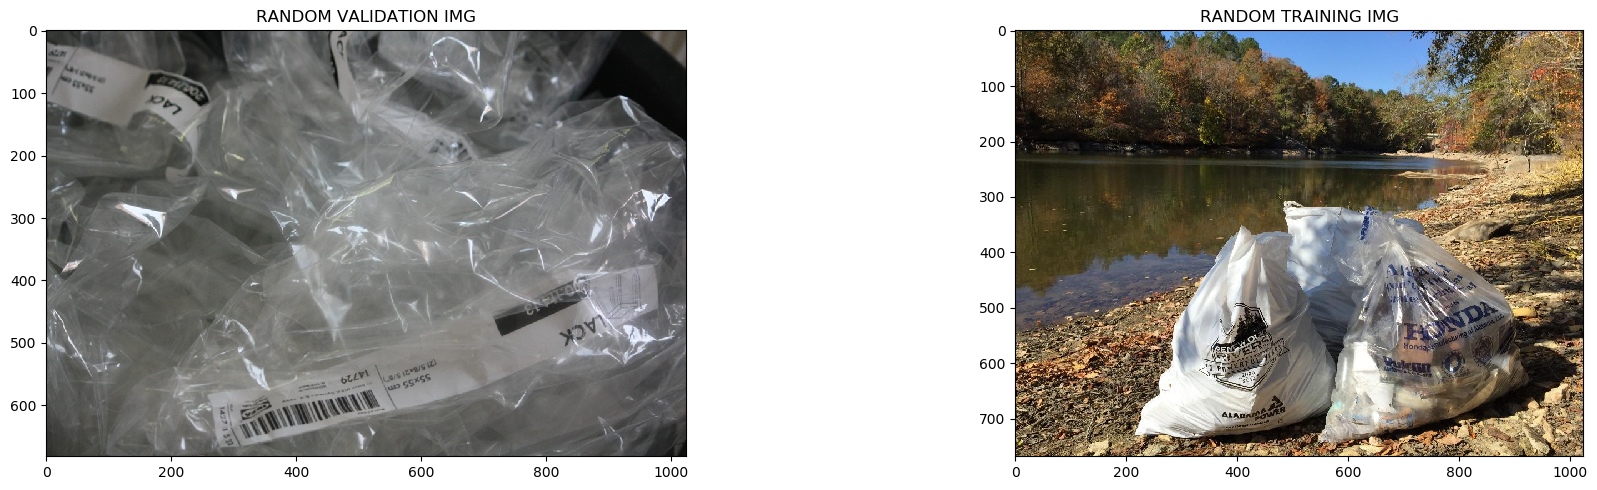

In [36]:
# img paths
img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]

# visualizer func.
def visualize_imgs(paths):
    
    # set-up plot.
    num_imgs = len(paths)
    fig, axes = plt.subplots(1, num_imgs, figsize=(10 * num_imgs, 5))
    
    # run the for-loop to pick a random img out of each of the two paths.
    for i, path in enumerate(paths):
        img_list = glob.glob(path)
        random_img = mpimg.imread(img_list[random.randint(0, len(img_list) - 1)])
        ax = axes[i] if num_imgs > 1 else axes 
        if 'validation' in path:
            ax.set_title("RANDOM VALIDATION IMG")
        if 'train' in path:
            ax.set_title("RANDOM TRAINING IMG")
        ax.imshow(random_img)

    plt.tight_layout()  # To prevent overlapping labels and titles
    plt.show()

# call function.
visualize_imgs(img_paths)

## APPLYING BOUNDING BOXES TO THE PLASTIC IMAGES ⏹️

**Purpose of Bounding Boxes**:

- Bounding boxes are used to mark regions of interest or objects within an images (our region of interest is the plastic within the images) These boxes are defined by coordinates and dimensions. Within the **detections.csv** data for the training and validation images, we're given the following information: (XMin, XMax, YMin, YMax).

**Coordinate System and Scaling**:

- The variables listed above are the bounding box coordinates and are given as fractions between 0 and 1, rather than pixel values. These fractional coordinates need to be scaled to match the dimensions of the actual image.

- To scale the bounding box coordinates, we essentially want to:
    - Take the given fractional x-coordinates (x_min and x_max) and multiply by the image width to get the actual pixel values for the left and right sides of the bounding box.
    - Take the given fractional y-coordinates (y_min and y_max) and multiply by the image height to get the actual pixel values for the top and bottom sides of the bounding box.
    
**Creating the Bounding Box**:

- We're going to use the Matplotlib library to visualize the bounding boxes. Rectangle's are to be used as the "bounding box" using the patches.rectangle function from Matplotlib. This function takes the scaled coordinates, width, and height as arguments to draw the bounding box.

The goal is to automate the details stated above for all the images in the training and validation images folder inside the dataset.
In the code below, lets write a function to draw bounding boxes around the plastic entities within random images from each training and validation dataset.

THE PATH OF THE RANDOM IMG SELECTED IS:  data/train/data/221dd6f9138951a7.jpg
THE RANDOM IMG'S ID IS:  221dd6f9138951a7


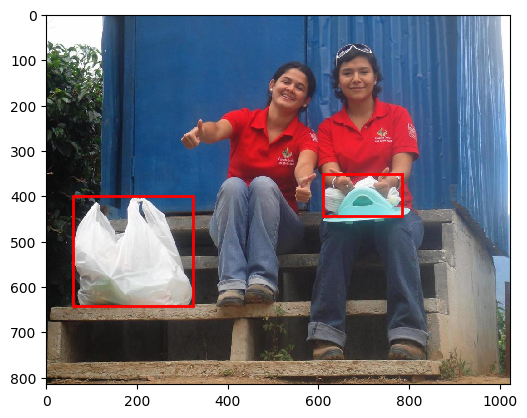

In [7]:
# img paths
img_paths = ["data/validation/data/*.jpg", "data/train/data/*.jpg"]

# func to draw bounding boxes around randomly selected images in the training and validation datasets.
def draw_bounding_boxes(path):
    
    # assigning the appropriate datasets.
    if 'train' in path:
        df = df_train
    elif 'validation' in path:
        df = df_val
    
    # retrieve list of paths of all the imgs within the current dataset split.
    all_imgs_list = glob.glob(path)
    
    # select a random img to draw the bounding-box around, and retrieve its id.
    random_img = all_imgs_list[random.randint(0, len(all_imgs_list) - 1)]
    random_img_id = random_img.split("/")[-1].split(".")[0]
    print("THE PATH OF THE RANDOM IMG SELECTED IS: ", random_img)
    print("THE RANDOM IMG'S ID IS: ", random_img_id)
    
    # selecting only the rows where the data matches our requirements. 
    # our requirements are the random img to draw the bounding boxes around, and the plastic class identifier.
    img = Image.open(random_img)
    desired_df_rows = df_rows = df.loc[(df.ImageID == random_img_id) & (df.LabelName == '/m/05gqfk')]
    
    # retrieving the image's original dimensions.
    img_width, img_height = img.size
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    # loop over as many plastic bounding boxes info we have for a given image's row.
    for idx, row in desired_df_rows.iterrows():
        
        # store the current image's bounding box requirements.
        curr_xmin = row['XMin']
        curr_xmax = row['XMax']
        curr_ymin = row['YMin']
        curr_ymax = row['YMax']
        
        # modify the current image's bounding box requirements by multiplying by the factor for each axe's min&max.
        new_xmin = curr_xmin * img_width
        new_xmax = curr_xmax * img_width
        new_ymin = curr_ymin * img_height
        new_ymax = curr_ymax * img_height
        
        # retrieve the bounding boxes height and width.
        width = new_xmax - new_xmin
        height = new_ymax - new_ymin
        
        # draw the bounding box.
        rect = patches.Rectangle((new_xmin,new_ymin), width, height, linewidth = 2, edgecolor = 'r', facecolor = 'none')
        ax.add_patch(rect)
    plt.show()
    
draw_bounding_boxes(img_paths[1])

## CLEANING OUR DATA 🧹

- Essentially, our goal is to retain only pertinent information from the '**detections.csv**' file for the training and validation images. The information that we're going to filter based off to 'clean' the .csv's is the images that contain our desired plastic class identifier: '/m/05gqfk'.

- When running the code to check the length of the cleansed dataframes for each split, we get a number out, which represents the total amount of "proper" rows in the df (proper rows is defined as: rows that have plastic data in them with which we can draw bounding boxes around for the respective image). 

In [6]:
def clean_csv_files(df_train_cleansed, df_val_cleansed):
    df_train_cleansed = df_train[df_train['LabelName'].str.contains('/m/05gqfk')]
    df_val_cleansed = df_val[df_val['LabelName'].str.contains('/m/05gqfk')]
    
    return df_train_cleansed, df_val_cleansed

df_train_cleansed, df_val_cleansed = clean_csv_files(df_train, df_val)
print("THERE ARE:", len(df_train_cleansed), "CLEANSED TRAINING PLASTIC ROWS WITH BOUNDING BOXES.")
print("THERE ARE:", len(df_val_cleansed), "CLEANSED VALIDATION PLASTIC ROWS WITH BOUNDING BOXES.")

print("\nA GLIMPSE OF THE CLEANSED VAL CSV BELOW:")
display(df_val_cleansed.head())

print("\nA GLIMPSE OF THE CLEANSED TRAIN CSV BELOW:")
display(df_train_cleansed.head())

THERE ARE: 366 CLEANSED TRAINING PLASTIC ROWS WITH BOUNDING BOXES.
THERE ARE: 9 CLEANSED VALIDATION PLASTIC ROWS WITH BOUNDING BOXES.

A GLIMPSE OF THE CLEANSED VAL CSV BELOW:


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
26213,1602934b52b119cc,xclick,/m/05gqfk,1,0.000000,1.000000,0.000000,1.00000,1,0,1,0,0
86384,488ab15e2780bec9,xclick,/m/05gqfk,1,0.000000,1.000000,0.023599,1.00000,0,0,1,0,0
92793,4e24222b68123ef3,xclick,/m/05gqfk,1,0.377083,0.745833,0.778125,0.96875,0,0,0,0,0
98200,527bec033e8298a5,xclick,/m/05gqfk,1,0.107813,0.995313,0.106250,0.99375,0,0,0,0,0
148850,7e25a4a33611d933,xclick,/m/05gqfk,1,0.000000,1.000000,0.000000,1.00000,0,0,1,0,0



A GLIMPSE OF THE CLEANSED TRAIN CSV BELOW:


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
8282,0005a922e055c723,xclick,/m/05gqfk,1,0.000000,0.999375,0.000000,0.998889,0,1,...,0,0,0.546875,0.700000,0.000000,0.999375,0.000000,0.998889,0.000000,0.593333
8733,000610ca2148a5ec,xclick,/m/05gqfk,1,0.163227,0.811445,0.051875,0.936875,0,0,...,0,0,0.740150,0.163227,0.811445,0.811445,0.051875,0.161250,0.936875,0.936875
10247,00075e339f3d4f37,xclick,/m/05gqfk,1,0.017578,0.999023,0.000000,0.998529,0,1,...,0,0,0.263672,0.999023,0.516602,0.017578,0.000000,0.107353,0.998529,0.385294
12496,00097c09aca0cabf,xclick,/m/05gqfk,1,0.112000,0.634000,0.000000,0.909414,1,1,...,0,0,0.355000,0.634000,0.325000,0.112000,0.000000,0.390764,0.909414,0.600355
40914,002c60d5fbc94244,xclick,/m/05gqfk,1,0.375000,0.461250,0.646993,0.772829,0,0,...,0,0,0.433125,0.375000,0.461250,0.457500,0.646993,0.755011,0.766147,0.772829


## SPLITTING OUR DATA ✂️
- Now, to split the data, we have that by standard ML requirements we need a training, testing, and a validation split(s). We have the training and validation splits cleaned and ready to go, but.... wait... what about the test split? Let's address that and clear up a major confusion regarding the purpose of a test split!

- Essentially, a test split is a dataset that contains images for estimating the accuracy of our model **during training**. This is generally used interchangably with the validation split, which is a dataset that contains images for estimating the accuracy of the model **after training**.

- To create our 'test' split, lets let the sklearn module do the job! Out of the cleansed training dataframe, we'll assign around 80% of the images for training and the rest 20% for testing.

- For our training purposes, we'll now be concerned with the 'train' and 'test' splits.

In [7]:
# using sci-kit learn to split the train dataset into 'train' and 'test' datasets.
train, test = train_test_split(df_train_cleansed, test_size = 0.2, random_state = 45)

# create the directory for the test-images folder
# os.mkdir("data/test/data")

# retrieving the ids from the two respective splits created.
train_img_ids = train["ImageID"].values
test_img_ids = test["ImageID"].values

# iterate over the images we chose to originally split from (thus, we iterate over the train split).
for img_path in glob.glob("data/train/data/*.jpg"):
    
    # retrieve img-id.
    img_id = img_path.split("/")[-1].split(".")[0]
    
    # set-up conditions to either keep the img in both the train and test, or simply move it to only the test.
    if ((img_id in train_img_ids) and (img_id in test_img_ids)):
        shutil.copy(img_path, f"data/test/data/{img_id}.jpg")
    elif ((img_id not in train_img_ids) and (img_id in test_img_ids)):
        shutil.move(img_path, f"data/test/data/{img_id}.jpg")

## APPLYING DATA ENGINEERING TECHNIQUES ⚙️

- Now that we have the 'train' and 'test' dataframes finalized, let's engineer their features before we shoot 'em out for training the model!

- Essentially, we'll be removing columns we don't need within these two dataframes, appending new info that we might require, and preparing them for the .lst format that SageMaker expects the data to be in. 

**IMPORTANT NOTES**:

- MXNet is an open-source deep learning framework chosen by SageMaker for its built-in algorithm. MXNet is known for scalability and integration with cloud infrastructure. It's highly scalable, making it well-suited for handling machine learning tasks on cloud infrastructure, which aligns with AWS's capabilities. We'll be converting the 'train' and 'test' dataframes into .lst format, and we'll further convert the data into MXNet-based Record IO definitions.

- RecordIO is a file format designed to store and access substantial volumes of binary data, like images, in a sequential fashion with high efficiency. In the realm of image processing, it plays a pivotal role in ensuring rapid and effective data retrieval and manipulation, particularly when dealing with the extensive datasets often encountered in machine learning applications. To find additional information, please refer to this [link](https://mesos.apache.org/documentation/latest/recordio/).

In [8]:
# create copies of the train and test dataframes.
train_df = train.copy()
test_df = test.copy()

# rename columns.
train_df.rename(columns={"LabelName": "className"}, inplace=True)
test_df.rename(columns={"LabelName": "className"}, inplace=True)

# sageMaker-specific requirements.
train_df["header_cols"] = 2
train_df["label_width"] = 5
test_df["header_cols"] = 2
test_df["label_width"] = 5

# create the "ImagePath" column in the dataframes.
train_df["ImagePath"] = "data/" + train_df['ImageID'] + '.jpg'
test_df["ImagePath"] = "data/" + test_df['ImageID'] + '.jpg'

# reorder columns.
train_df = train_df[['header_cols', 'label_width', 'className', 'XMin', 'YMin', 'XMax', 'YMax', 'ImagePath']]
test_df = test_df[['header_cols', 'label_width', 'className', 'XMin', 'YMin', 'XMax', 'YMax', 'ImagePath']]

# set the display precision to 4.
pd.set_option("display.precision", 4)

# create final train and test dataframes with "className" set to "0.000".
final_train_df = train_df.copy()
final_train_df['className'] = "0.000"

final_test_df = test_df.copy()
final_test_df['className'] = "0.000"

# display the final dataframes.
print("\nTHE FINAL TRAINING DATA: ")
display(final_train_df.head())

print("\nTHE FINAL TESTING DATA: ")
display(final_test_df.head())


THE FINAL TRAINING DATA: 


,header_cols,label_width,className,XMin,YMin,XMax,YMax,ImagePath
1073090,2,5,0.000,0.8944,0.2542,0.9994,0.3752,data/0fab4e71052b9548.jpg
2387102,2,5,0.000,0.3713,0.6400,0.4850,0.8817,data/2642e4e681cec55b.jpg
644465,2,5,0.000,0.1944,0.5455,0.2844,0.7531,data/08a6765baa7c3b1a.jpg
3428585,2,5,0.000,0.5994,0.5126,0.7069,0.7591,data/3847796332c2741e.jpg
3119590,2,5,0.000,0.4544,0.5308,0.5319,0.6342,data/32eedcc25c63f627.jpg



THE FINAL TESTING DATA: 


,header_cols,label_width,className,XMin,YMin,XMax,YMax,ImagePath
715555,2,5,0.000,0.1422,0.2172,0.5797,0.4906,data/09d6dd4a55b2dd78.jpg
2387100,2,5,0.000,0.0163,0.6100,0.1638,0.8483,data/2642e4e681cec55b.jpg
824753,2,5,0.000,0.3356,0.0778,0.9994,0.9989,data/0b9a64abf7758be8.jpg
644466,2,5,0.000,0.2369,0.5437,0.3663,0.7840,data/08a6765baa7c3b1a.jpg
1048650,2,5,0.000,0.0000,0.0000,0.9994,0.9992,data/0f438192f88bbbb5.jpg


## DATA AUGMENTATION ⚒️

Data augmentation is a technique used in machine learning and computer vision to artificially increase the diversity of a dataset by making slight modifications to the existing data. This helps improve the performance and robustness of models during training.

- The transposition of images by flipping them across the y-axis is the augmentation technique that we're going to use. This action leads to the creation of new images, each with a flipped appearance. 

    - To maintain accurate object detection for our given task, we must adjust the bounding box coordinates because the original image's bounding boxes will no longer align with the new flipped image.
    
    - NOTES ON THE AUGMENTATION TECHNIQUE:
        - When we flip images across the Y-axis, the Y-coordinates of objects stay the same, while the X-coordinates change. This fundamental concept is crucial for properly adjusting bounding box coordinates. It's essential to understand that the X_min value becomes the new X_max value and vice versa due to this flipping process.

For more info refer to this [article](https://blog.paperspace.com/data-augmentation-for-bounding-boxes/) that describes what we're doing with respect to a different scenario.

In [ ]:
# creating the data augmentation function:
def data_augmentation(split):
    
    # validate the split, and assign the appropriate df, and init a counter for transposed image work.
    if split == "train":
        df = final_train_df
        counter = 0
    elif split == "test":
        df = final_test_df
        counter = 0
    else:
        print("INVALID SPLIT PARAM... PROVIDE A VALID SPLIT (e.g. TRAIN OR TEST)")
        return
    
    # create a transposed df to add the augmented info into.
    transposed_df = pd.DataFrame(columns=["header_cols", "label_width", "className", "XMin", "YMin", "XMax", "YMax", "ImagePath"], dtype = object)
    for idx, row in df.iterrows():
        
        # retrieve the current image path & image id.
        curr_img_path = row["ImagePath"]
        curr_img_id = curr_img_path.split('/')[-1].split('.')[0]
        
        # get current image info.
        image = Image.open(os.path.abspath(f"data/{split}/data/{curr_img_id}.jpg"))
        image_width, image_height = image.size
        
        # transposing the image.
        transposed_image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)
        transposed_image_path = f"data/transposed_{curr_img_id}.jpg"
        transposed_image.save(transposed_image_path)
        
        # modify the current image's bounding box requirements by multiplying by the factor for the X-axis' min & max.
        curr_xmin = row['XMin'] * image_width
        curr_xmax = row['XMax'] * image_width
        curr_ymin = row['YMin']
        curr_ymax = row['YMax']
        
        # getting the new coordinates for the transposed images' bounding boxes.
        transposed_xmin = ((image_width / 2) - (curr_xmin - (image_width / 2))) / image_width
        transposed_xmax = ((image_width / 2) - (curr_xmax - (image_width / 2))) / image_width
        
        # append the entires/info about the transposed image into the transposed df.
        transposed_df.loc[counter]=[2, 5, "0.000", transposed_xmin, curr_ymin, transposed_xmax, curr_ymax, transposed_image_path]
        counter += 1
    
    merged_df = df.append(transposed_df, ignore_index = True)
    merged_df.to_csv(f"{split}.lst", sep = "\t", float_format = "%.4f", header = None)

data_augmentation("train")
data_augmentation("test")

## CONFIRMING THE DATA AUGMENTATION (TRANSPOSE TECHNIQUE) ✅:

data/train/data/073dd5489a8faed7.jpg


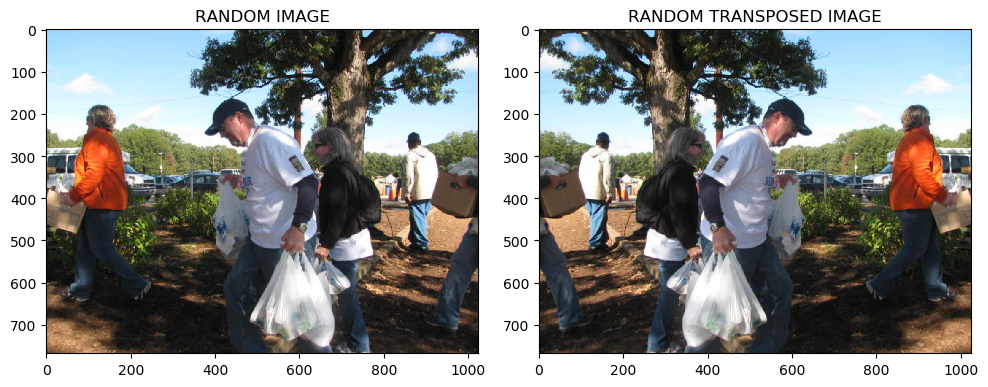

In [30]:
# function to find the corresponding transposed image for a given image filename.
def find_transposed_image(original_image_path):
    
    # find original image path details.
    image_dir = os.path.dirname(original_image_path)
    image_filename = os.path.basename(original_image_path)
    if "transposed" in image_filename:
        print("ORIGINALLY CHOSE A TRANSPOSED, IMAGE. RE-RUN THE CELL!")
        return
    
    # extract the image ID (assuming it's before the '.jpg' extension).
    image_id = image_filename.split('.')[0]
    
    # construct the filename for the transposed image.
    transposed_image_filename = f'transposed_{image_id}.jpg'
    transposed_image_path = os.path.join(image_dir, transposed_image_filename)
    
    # check if the transposed image exists.
    if os.path.exists(transposed_image_path):
        return transposed_image_path
    else:
        print("THIS TRANSPOSED IMAGE DOES NOT EXIST! TRY RE-RUNNING CELL AGAIN!")
        return None

# visualizer function
def visualize_images(path):
    
    # set-up plot.
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Assuming you want to display two images side by side

    # select a random image from the list
    img_list = glob.glob(path)
    random_img_path = random.choice(img_list)
    print(random_img_path)

    # find the corresponding transposed image
    transposed_img_path = find_transposed_image(random_img_path)

    # display the original image
    random_img = mpimg.imread(random_img_path)
    axes[0].set_title("RANDOM IMAGE")
    axes[0].imshow(random_img)
    
    # if a corresponding transposed image is found, display it alongside
    if transposed_img_path:
        transposed_img = mpimg.imread(transposed_img_path)
        axes[1].set_title("RANDOM TRANSPOSED IMAGE")
        axes[1].imshow(transposed_img)

    plt.tight_layout()  # to prevent overlapping labels and titles
    plt.show()

# Example usage with a single path
img_path = 'data/train/data/*.jpg'  # Adjust the file extension as needed
visualize_images(img_path)

## SET-UP SCRIPTS/DEPENDENCIES FOR TRAINING 📦:

We're simply setting-up the required software packages for the computer vision and deep learning development. It first checks the distribution, updates the package list, installs necessary packages, and then installs the "opencv-python" and "mxnet" packages using the system's Python interpreter.

I'm going to be using a script straight out of the tools provided by Apache MXNET (script is located at `tools/im2rec.py`):
- In summary, we'll use the im2rec.py script to preprocess and create record files for image datasets, making it suitable for training machine learning models using MXNet. The utility of the script can be studied through the code present within the stated directory! For more info, feel free to check [this](https://github.com/apache/mxnet) out.

In [ ]:
# check if the Linux distribution is "debian."
if platform.linux_distribution()[0] == "debian":
    # if it is, execute the following shell commands:
    # Update the package manager's package list.
    ! apt-get update

    # install the required packages - ffmpeg, libsm6, and libxext6.
    ! apt-get install ffmpeg libsm6 libxext6 -y

# install the 'opencv-python' package.
!{sys.executable} -m pip install opencv-python

# install the 'mxnet' package.
!{sys.executable} -m pip install mxnet

In [ ]:
RESIZE_SIZE = 256
BASE_DIR = "data/"
!python tools/im2rec.py --resize 256 --pack-label test $BASE_DIR/test/
!python tools/im2rec.py --resize 256 --pack-label train $BASE_DIR/train/

## UPLOADING DATA TO AWS S3 BUCKET 🪣:
A picture of my AWS bucket's main directories is attached below for reference:
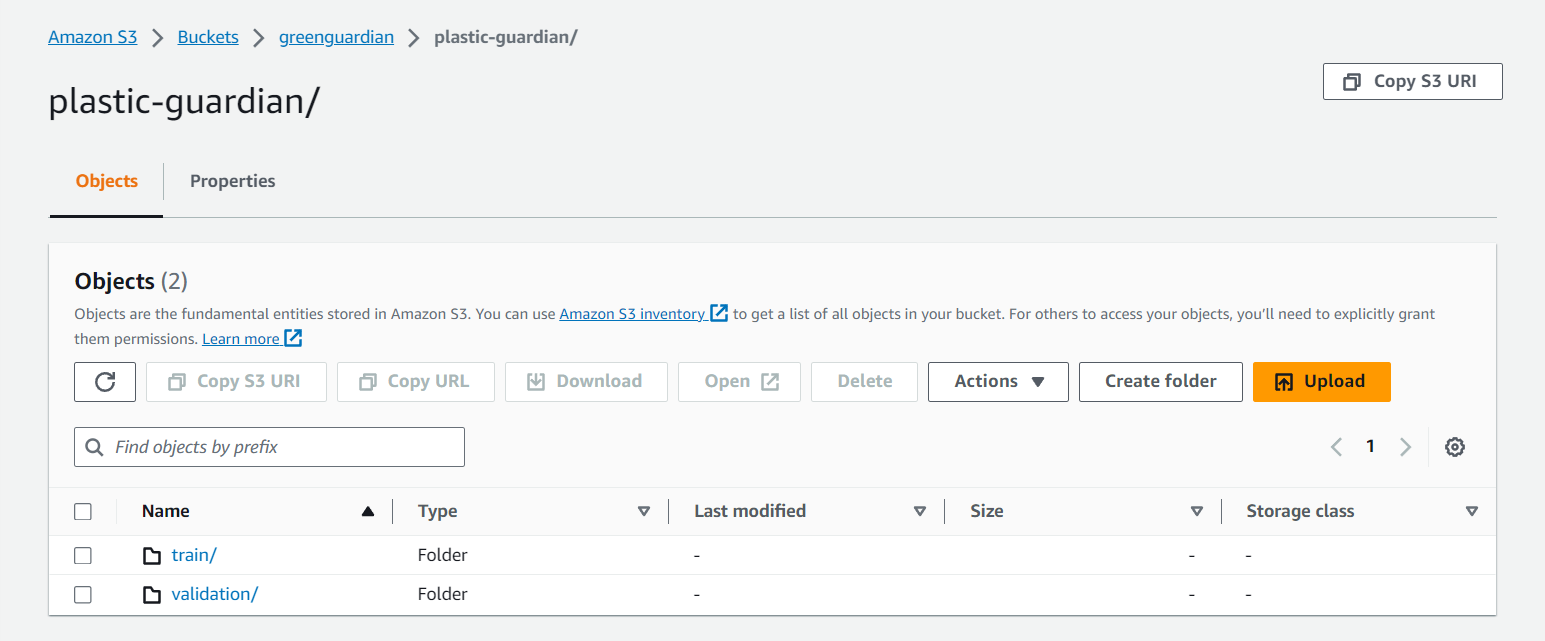

In [9]:
# specifying the name of my S3 bucket.
s3_bucket = "greenguardian"

# specifying the prefix at which we're going to save my .rec files.
# creating specific s3 channels for each splits' .rec data.
prefix = "plastic-guardian"
train_channel = prefix + "/train"
validation_channel = prefix + "/validation" # named validation, but its our test channel.

# get the IAM role.
role = get_execution_role()

# set-up the sagemaker session.
session = sagemaker.Session()

# upload the train and test data.
session.upload_data(path="train.rec", bucket=s3_bucket, key_prefix=train_channel)
s3_train_data = "s3://{}/{}".format(s3_bucket,train_channel)

session.upload_data(path= "test.rec", bucket=s3_bucket, key_prefix=validation_channel)
s3_validation_data = "s3://{}/{}".format(s3_bucket,validation_channel)

## BEGINNING THE TRAINING PROCESS 🤖:

In [21]:
def total_amt_of_training_images():
    counter = 0
    for i in glob.glob('data/train/data/*.jpg'):
        counter += 1
    return counter

# retrieving the Docker image URI for the respective framework in the respective region.
training_docker_image = image_uris.retrieve(
    region = session.boto_region_name, 
    framework = "object-detection",
    version = "1"
)

# creating the estimator to train the model.
green_guardian_ml_model = sagemaker.estimator.Estimator(
    training_docker_image, # docker container img.
    role, # IAM role.
    instance_count = 1, # number of AWS EC2 instances used for training.
    instance_type = "ml.p3.2xlarge", # AWS GPU instance for DL-tasks.
    volume_size = 50, # size of the EBS volume in GB to use for storing data during training.
    max_run = 360000, # maximum amount of time in seconds that the training job can run for.
    input_mode = "File", # input type to the model.
    output_path = "s3://{}/{}/model_outputs".format(s3_bucket, prefix), # S3 location to which the trained model artifacts will be saved.
    sagemaker_session = session, # specify the sagemaker session.
)

# set hyperparameters:
green_guardian_ml_model.set_hyperparameters(
    base_network = "resnet-50", # base neural network architecture that the model will use, we'll set to resnet-50.
    use_pretrained_model = 1,
    num_classes = 1, # has to predict one plastic class only.
    epochs = 100, 
    lr_scheduler_step = "50,70,80,90,95", #  specifies the epochs at which the learning rate should be adjusted by a given factor.
    lr_scheduler_factor = 0.1, # lr adjustment factor as stated above ^ .
    momentum = 0.9, # SGD (Stochastic Gradient Descent) param, helps the optimization process by adding inertia in the direction of the global minimum.
    weight_decay = 0.0005, # regularizing to avoid overfitting.
    nms_threshold = 0.45, # threshold to filter out redundant bounding box predictions (often used in obj-detection stuff).
    image_shape = 512, # sets the shape of the input images to the model.
    num_training_samples = total_amt_of_training_images() 
)